In [ ]:
!pip install timm
!pip install gradio
!pip install inflect
!pip install phonemizer
!pip install --upgrade transformers

!sudo apt-get update
!pip install py-espeak-ng
!sudo apt-get install espeak-ng

In [2]:
# Standard Library Imports
import os
import json
import torch
import warnings
import http.client
import gradio as gr

## Hugging Face Transformers
import transformers
from transformers import pipeline
from transformers.utils import logging
from transformers import AutoModelForCausalLM, AutoTokenizer

# image rendering
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image, display
from PIL import Image, ImageDraw, ImageFont

#audio rendering
from IPython.display import Audio as IPythonAudio

## Google Colab
from google.colab import userdata

# Configuration
logging.set_verbosity_error()
warnings.filterwarnings('ignore')

In [3]:
# check for cuda if available assign to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
# Building Object Detection Pipeline
od_pipe = pipeline("object-detection", "facebook/detr-resnet-50", device=device)

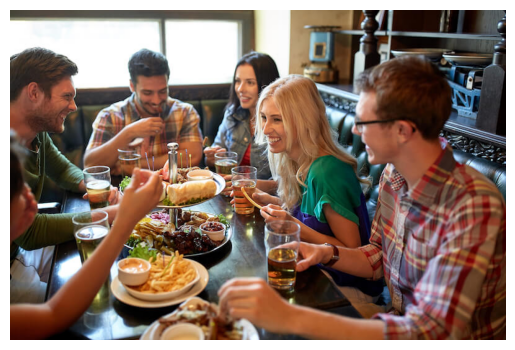

In [5]:
# Load and display the image
img = mpimg.imread('/content/PeopleatResturant.jpg')
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

In [6]:
# pass image to the pipeline
output = od_pipe('/content/PeopleatResturant.jpg')

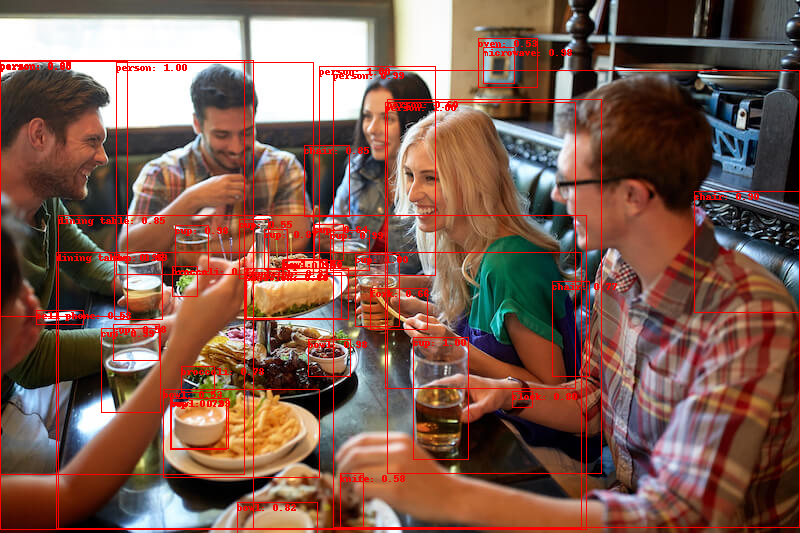

In [7]:
#Draw bounding boxes on the image
def draw_boxes(image_path, outputs):
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()

    for item in outputs:
        box = item['box']
        label = item['label']
        score = item['score']

        draw.rectangle([(box['xmin'], box['ymin']), (box['xmax'], box['ymax'])], outline="red", width=1)
        draw.text((box['xmin'], box['ymin']), f"{label}: {score:.2f}", fill="red", font=font)

    return image

#Visualize the image with bounding boxes
result_image = draw_boxes('/content/PeopleatResturant.jpg', output)
display(result_image)

### Let's build an Application

In [8]:
# Helper function to render results on the image
def render_results_in_image(image, results):
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()

    for item in results:
        box = item['box']
        label = item['label']
        score = item['score']

        draw.rectangle([(box['xmin'], box['ymin']), (box['xmax'], box['ymax'])], outline="red", width=1)
        draw.text((box['xmin'], box['ymin']), f"{label}: {score:.2f}", fill="red", font=font)

    return image

# Function to get pipeline prediction and render results
def get_pipeline_prediction(pil_image):
    # Convert PIL image to the format required by the pipeline
    pil_image = pil_image.convert("RGB")
    pipeline_output = od_pipe(pil_image)
    processed_image = render_results_in_image(pil_image, pipeline_output)
    return processed_image

# Define the Gradio interface
demo = gr.Interface(
    fn=get_pipeline_prediction,
    inputs=gr.Image(label="Input image", type="pil"),
    outputs=gr.Image(label="Output image with predicted instances", type="pil")
)

# Launch the Gradio interface
demo.launch(share=True, server_port=int(os.getenv('PORT', 7862)))

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://d8ab0ba1adda079bd9.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [9]:
demo.close()

Closing server running on port: 7862


### Build pipeline, to convert image to text to voice

In [10]:
raw_image = od_pipe('/content/PeopleatResturant.jpg')

In [11]:
raw_image

[{'score': 0.5828678607940674,
  'label': 'cell phone',
  'box': {'xmin': 36, 'ymin': 310, 'xmax': 83, 'ymax': 324}},
 {'score': 0.9936004877090454,
  'label': 'cup',
  'box': {'xmin': 330, 'ymin': 230, 'xmax': 369, 'ymax': 270}},
 {'score': 0.9873718023300171,
  'label': 'bowl',
  'box': {'xmin': 171, 'ymin': 398, 'xmax': 228, 'ymax': 448}},
 {'score': 0.8085976839065552,
  'label': 'sandwich',
  'box': {'xmin': 246, 'ymin': 268, 'xmax': 348, 'ymax': 319}},
 {'score': 0.5690945386886597,
  'label': 'bowl',
  'box': {'xmin': 283, 'ymin': 260, 'xmax': 327, 'ymax': 279}},
 {'score': 0.9911057353019714,
  'label': 'cup',
  'box': {'xmin': 101, 'ymin': 328, 'xmax': 160, 'ymax': 412}},
 {'score': 0.9936268329620361,
  'label': 'person',
  'box': {'xmin': 333, 'ymin': 70, 'xmax': 799, 'ymax': 527}},
 {'score': 0.7738106846809387,
  'label': 'chair',
  'box': {'xmin': 552, 'ymin': 281, 'xmax': 589, 'ymax': 376}},
 {'score': 0.9028964042663574,
  'label': 'chair',
  'box': {'xmin': 694, 'ymin'

### Lets use gemma to obtain a detailed description of the labels

In [12]:
# Function to format object information
def format_objects(objects):
    formatted_objects = ""
    for obj in objects:
        formatted_objects += f"Label: {obj['label']}, Confidence: {obj['score']:.2f}, Coordinates: (xmin: {obj['box']['xmin']}, ymin: {obj['box']['ymin']}, xmax: {obj['box']['xmax']}, ymax: {obj['box']['ymax']})\n"
    return formatted_objects

label_data = format_objects(raw_image)

In [13]:
# Define the base prompt
base_prompt = """
You are an AI transcriber. Your task is to obtain the information from the following label descriptions and\
provide a clear and concise summary of the item, objects, and information in the image.

Labels and Boxes:
{{LABELS}}

Please provide a concise summary of the image content.
"""

# Replace the placeholder with the formatted object information
prompt = base_prompt.replace("{{LABELS}}", label_data)

In [14]:
# Load environment variables
api_key = userdata.get('GENAI_KEY')
api_url = userdata.get('GENAI_API')

# Establish connection
conn = http.client.HTTPSConnection(api_url)

# Headers for the request
headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {api_key}"
}

# Define the model ID
model_id = "meta-llama/llama-3-70b-instruct"

def create_payload(prompt):
    return json.dumps(
        {
            "model_id": model_id,
            "parameters": {
                "decoding_method": "sample",
                "temperature": 0.7,
                "top_k": 10,
                "length_penalty": {"decay_factor": 1.5, "start_index": 100},
                "max_new_tokens": 250,
            },
            "moderations": {},
            "input": "user\n\n" + prompt + "\n\nassistant",
            "data": {}
        }
    )

def describe_scene(prompt):
    payload = create_payload(prompt)
    conn.request("POST", "/v2/text/generation?version=2024-03-19", body=payload, headers=headers)
    response = conn.getresponse()
    data = response.read().decode('utf-8')
    result = json.loads(data)
    if response.status == 200:
        return result['results'][0]['generated_text']
    else:
        raise Exception(f"Error: {response.status}, {result}")

# Get the description
description = describe_scene(prompt)
print(description)

<|end_header_id|>

Here is a concise summary of the image content:

The image depicts a dining scene with multiple people (at least 5) sitting around a dining table. The table is set with various objects, including cups, bowls, sandwiches, broccoli, forks, and knives. There are also chairs, a microwave, and an oven in the vicinity. Additionally, a clock is visible on the wall. The scene appears to be a casual, everyday meal gathering.


### Build pipeline to convert text to speech

In [15]:
tts_pipe = pipeline(task="text-to-speech",
                    model="kakao-enterprise/vits-ljs")

In [20]:
narrated_text = tts_pipe(description)

In [21]:
IPythonAudio(narrated_text["audio"][0],
             rate=narrated_text["sampling_rate"])